In [23]:
import pandas as pd
import json

def __merge(customer_filename: str, transaction_filename: str, fraud_filename: str) -> pd.DataFrame:
    customers_df = pd.read_csv(customer_filename)
    transactions_df = pd.read_parquet(transaction_filename)
    with open(fraud_filename, 'r') as f:
        fraud_dict = json.load(f)
    
    fraud_df = pd.DataFrame(list(fraud_dict.items()), columns=['trans_num', 'is_fraud'])
    
    transactions_df = transactions_df.reset_index()


    merged_df = transactions_df.merge(customers_df, on='cc_num', how='left')

    merged_df = merged_df.merge(fraud_df, on='trans_num', how='left')
    
    merged_df = merged_df.sort_values('trans_date_trans_time')
    
    return merged_df

merged_data = __merge('../data_sources/customer_release.csv', 
                      '../data_sources/transactions_release.parquet', 
                      '../data_sources/fraud_release.json')

In [24]:
merged_data.head()

,trans_num,index_x,trans_date_trans_time,cc_num,unix_time,merchant,category,amt,merch_lat,merch_long,...,street,city,state,zip,lat,long,city_pop,job,dob,is_fraud
71408,0b242abb623afc578575680df30655b9,0,2019-01-01 00:00:18,2703186189652095,1.325376e+09,None,MISC_NET,4.97,36.011293,-82.048315,...,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"PSYCHOLOGIST, COUNSELLING","Mar 09, 1988",0.0
202364,1f76529f8574734946361c461b024d99,1,2019-01-01 00:00:44,630423337322,1.325376e+09,None,GROCERY_POS,107.23,49.159047,-118.186462,...,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,21-Jun-1978,0.0
1040107,a1a22d70485983eac12b5b88dad1cf95,2,2019-01-01 00:00:51,38859492057661,1.325376e+09,fraud_Lind-Buckridge,entertainment,220.11,43.150704,-112.154481,...,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,19-Jan-1962,0.0
692044,6b849c168bdad6f867558c3793159a81,3,2019-01-01 00:01:16,3534093764340240,1.325376e+09,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,47.034331,-112.561071,...,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,12-Jan-1967,0.0
1055958,a41d7549acf90789359a9aa5346dcb46,4,2019-01-01 00:03:06,375534208663984,1.325376e+09,fraud_Keeling-Crist,MISC_POS,41.96,38.674999,-78.632459,...,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,DANCE MOVEMENT PSYCHOTHERAPIST,28/03/1986,0.0


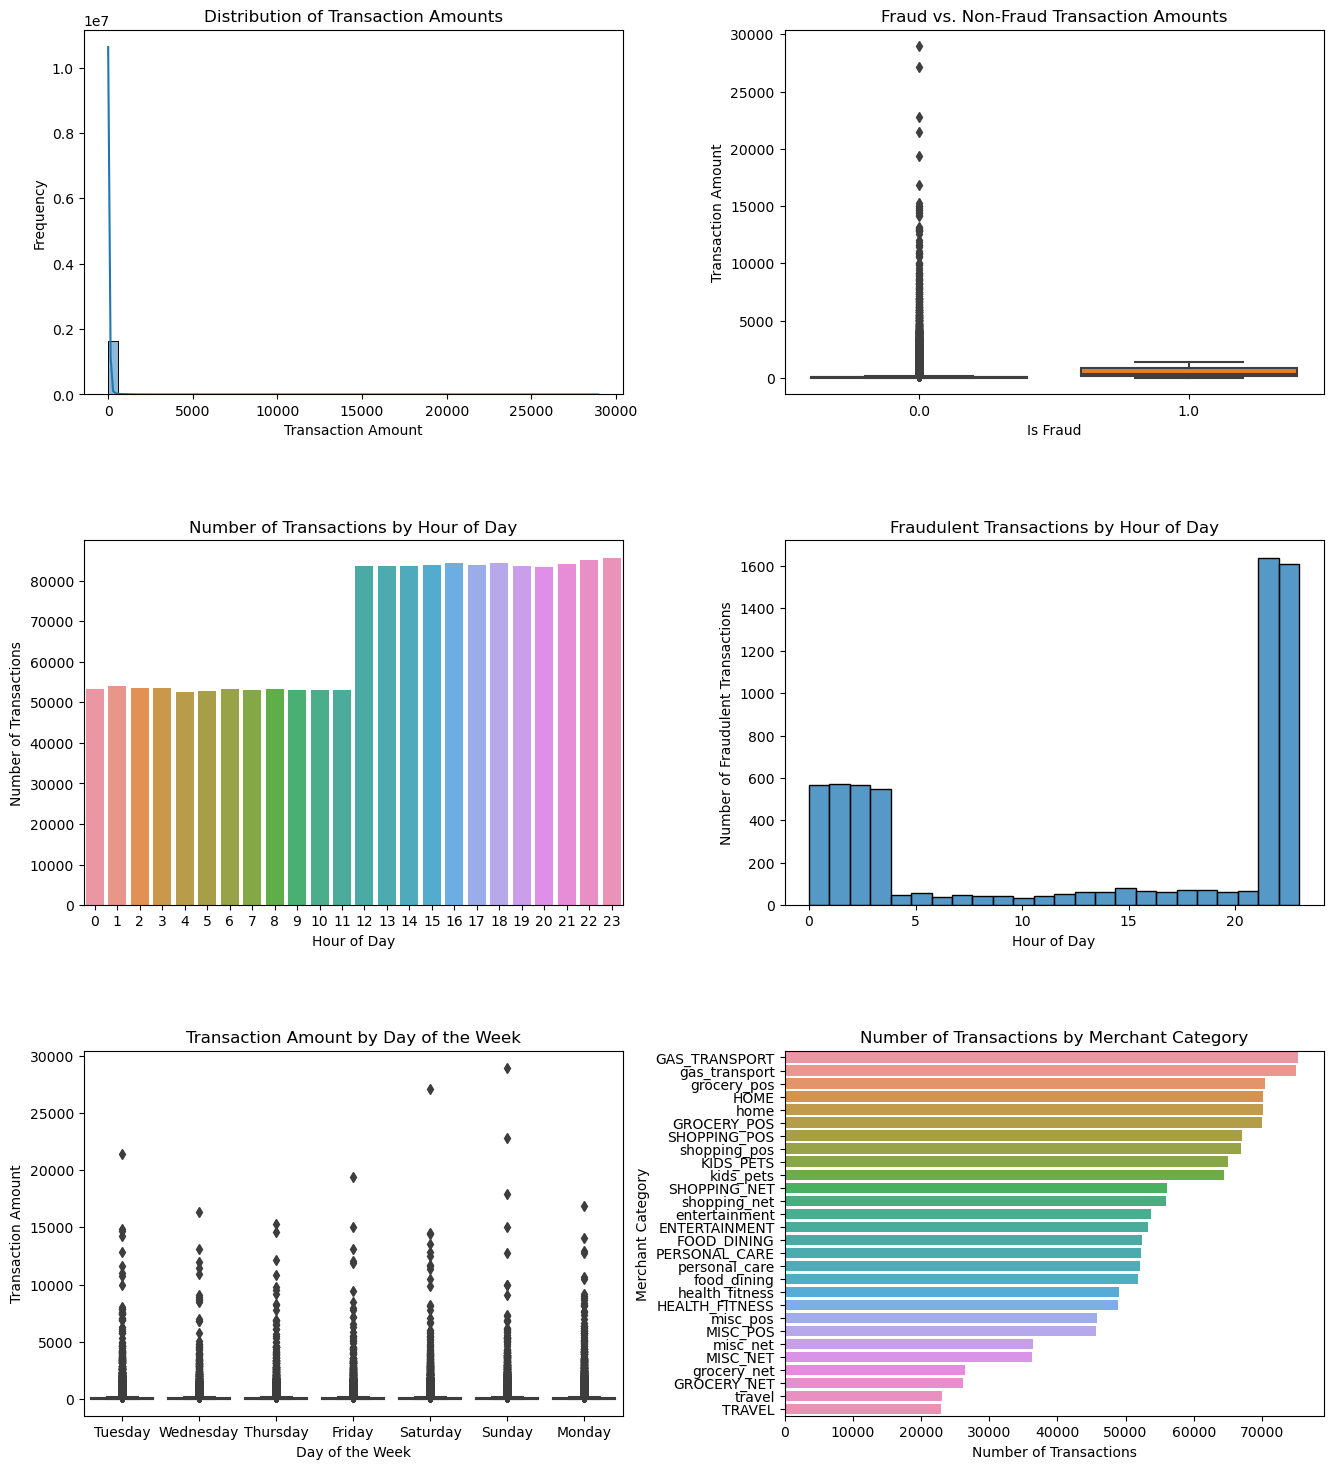

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert trans_date_trans_time to datetime if it's not already
merged_data['trans_date_trans_time'] = pd.to_datetime(merged_data['trans_date_trans_time'])

# Create a 3x2 grid for 6 plots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Distribution of Transaction Amounts
sns.histplot(merged_data['amt'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Transaction Amounts')
axes[0, 0].set_xlabel('Transaction Amount')
axes[0, 0].set_ylabel('Frequency')

# Fraud vs. Non-Fraud Transaction Amounts
sns.boxplot(x='is_fraud', y='amt', data=merged_data, ax=axes[0, 1])
axes[0, 1].set_title('Fraud vs. Non-Fraud Transaction Amounts')
axes[0, 1].set_xlabel('Is Fraud')
axes[0, 1].set_ylabel('Transaction Amount')

# Number of Transactions by Hour of Day
merged_data['trans_hour'] = merged_data['trans_date_trans_time'].dt.hour
sns.countplot(x='trans_hour', data=merged_data, ax=axes[1, 0])
axes[1, 0].set_title('Number of Transactions by Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Transactions')

# Fraudulent Transactions by Hour of Day
sns.histplot(data=merged_data[merged_data['is_fraud'] == 1], x='trans_hour', bins=24, kde=False, ax=axes[1, 1])
axes[1, 1].set_title('Fraudulent Transactions by Hour of Day')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Fraudulent Transactions')

# Transaction Amount by Day of the Week
merged_data['day_of_week'] = merged_data['trans_date_trans_time'].dt.day_name()
sns.boxplot(x='day_of_week', y='amt', data=merged_data, ax=axes[2, 0])
axes[2, 0].set_title('Transaction Amount by Day of the Week')
axes[2, 0].set_xlabel('Day of the Week')
axes[2, 0].set_ylabel('Transaction Amount')

# Number of Transactions by Merchant Category
sns.countplot(y='category', data=merged_data, order=merged_data['category'].value_counts().index, ax=axes[2, 1])
axes[2, 1].set_title('Number of Transactions by Merchant Category')
axes[2, 1].set_xlabel('Number of Transactions')
axes[2, 1].set_ylabel('Merchant Category')

plt.show()

Given the graphs we see here, we can tell that most fraudulent activity happens at night between the hours of 10 and 3, and that most transactions that are classified as fraud are for smaller amounts.